# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
The aim of this project is to identify lane lines in a video of highway driving. The video results can be whatched directly at the bottom of this Jupyter Notebook. Line detection is performed first on individual images and then on video footage by repeating the same process on each frame.


## Import Packages

In [1]:
# importing some useful packages
%load_ext nb_black
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

%matplotlib inline

<IPython.core.display.Javascript object>

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


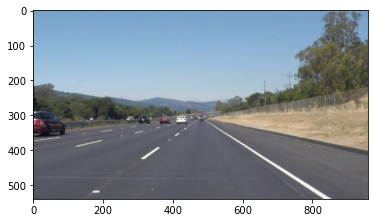

<IPython.core.display.Javascript object>

In [2]:
# reading in an image
image = mpimg.imread("test_images/solidWhiteRight.jpg")

# printing out some stats and plotting
print("This image is:", type(image), "with dimensions:", image.shape)
plt.imshow(image)

## Helper Functions

In [3]:
import math


def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)


def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


def region_of_interest(img, vertices):
    """
    Applies an image mask.

    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    # defining a blank mask to start with
    mask = np.zeros_like(img)

    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=5):

    rm = []
    rcx = []
    rcy = []
    weightr = []
    ybottomr = img.shape[0]
    ytopr = img.shape[0]

    lm = []
    lcx = []
    lcy = []
    weightl = []
    ybottoml = img.shape[0]
    ytopl = img.shape[0]

    smoothing_parameter = 15

    for line in lines:
        for x1, y1, x2, y2 in line:
            slope = (y2 - y1) / (x2 - x1)
            center = ((x2 + x1) / 2, (y2 + y1) / 2)
            distance = math.sqrt(((x2 - x1) ** 2) + ((y2 - y1) ** 2))
            if 0.82 > abs(slope) > 0.49:
                if np.sign(slope) == 1:
                    lm.append(slope)
                    lcx.append(center[0])
                    lcy.append(center[1])
                    weightl.append(distance)
                    if y1 < ytopl:
                        ytopl = y1
                    if y2 < ytopl:
                        ytopl = y2
                else:
                    rm.append(slope)
                    rcx.append(center[0])
                    rcy.append(center[1])
                    weightr.append(distance)
                    if y1 < ytopr:
                        ytopr = y1
                    if y2 < ytopr:
                        ytopr = y2

    if len(rcx) != 0:
        zr = np.polyfit(rcx, rcy, 1, w=weightr)
        fr = np.poly1d(zr)
        if -0.8 < fr.coef[0] < -0.49:
            ytopr_history.append(ytopr)
            if len(ytopr_history) > smoothing_parameter:
                ytopr_history.pop(0)
            ytopr = sum(ytopr_history) / len(ytopr_history)
            yr = [ybottomr, ytopr]
            xr = [(fr - yr[0]).roots, (fr - yr[1]).roots]
            cv2.line(
                img, (int(xr[0]), yr[0]), (int(xr[1]), int(yr[1])), color, thickness,
            )

    if len(lcx) != 0:
        zl = np.polyfit(lcx, lcy, 1, w=weightl)
        fl = np.poly1d(zl)
        if 0.8 > fl.coef[0] > 0.49:
            ytopl_history.append(ytopl)
            if len(ytopl_history) > smoothing_parameter:
                ytopl_history.pop(0)
            ytopl = sum(ytopl_history) / len(ytopl_history)
            yl = [ybottoml, ytopl]
            xl = [(fl - yl[0]).roots, (fl - yl[1]).roots]
            cv2.line(
                img, (int(xl[0]), yl[0]), (int(xl[1]), int(yl[1])), color, thickness,
            )


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.

    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(
        img,
        rho,
        theta,
        threshold,
        np.array([]),
        minLineLength=min_line_len,
        maxLineGap=max_line_gap,
    )
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img


def weighted_img(img, initial_img, α=0.8, β=1.0, γ=0.0):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.

    `initial_img` should be the image before any processing.

    The result image is computed as follows:

    initial_img * α + img * β + γ
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

<IPython.core.display.Javascript object>

## Test Images

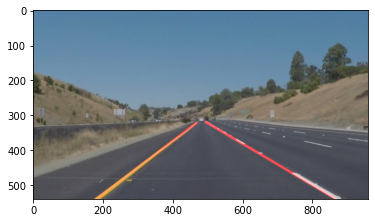

<IPython.core.display.Javascript object>

In [4]:
import os

global ytopr_history
ytopr_history = []
global ytopl_history
ytopl_history = []

files = os.listdir("test_images/")

for file in files:
    ytopr_history.clear()
    ytopl_history.clear()
    if file[0:6] != "output":
        image_img = mpimg.imread("test_images/" + file)
        image_gray = grayscale(image_img)
        image_gray = gaussian_blur(image_gray, 3)
        image_edges = canny(image_gray, 60, 180)
        image_imshape = image_img.shape

        image_vertices = np.array(
            [
                [
                    (0.51 * image_imshape[1], image_imshape[0] * 0.58),
                    (0.49 * image_imshape[1], image_imshape[0] * 0.58),
                    (0, image_imshape[0]),
                    (image_imshape[1], image_imshape[0]),
                ]
            ],
            dtype=np.int32,
        )

        image_target = region_of_interest(image_edges, image_vertices)
        image_lines = hough_lines(image_target, 1, np.pi / 180, 35, 5, 2)
        image_result = weighted_img(image_lines, image_img, α=0.8, β=1.0)
        plt.imshow(image_result, cmap="gray")
        r, g, b = cv2.split(image_result)
        image_result = cv2.merge((b, g, r))
        cv2.imwrite("test_images/output" + file, image_result)

## Test on Videos

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [5]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

<IPython.core.display.Javascript object>

In [6]:
def process_frame(frame):
    frame_gray = grayscale(frame)
    frame_gray = gaussian_blur(frame_gray, 3)
    frame_edges = canny(frame_gray, 60, 180)
    frame_imshape = frame.shape

    frame_vertices = np.array(
        [
            [
                (0.51 * frame_imshape[1], frame_imshape[0] * 0.58),
                (0.49 * frame_imshape[1], frame_imshape[0] * 0.58),
                (0, frame_imshape[0]),
                (frame_imshape[1], frame_imshape[0]),
            ]
        ],
        dtype=np.int32,
    )

    frame_target = region_of_interest(frame_edges, frame_vertices)
    frame_lines = hough_lines(frame_target, 1, np.pi / 180, 35, 5, 2)
    frame_result = weighted_img(frame_lines, frame, α=0.8, β=1.0)
    return frame_result

<IPython.core.display.Javascript object>

Let's try the one with the solid white lane on the right first.

In [7]:
white_output = "test_videos_output/solidWhiteRight.mp4"
ytopr_history.clear()
ytopl_history.clear()
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_frame)  # NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|          | 0/221 [00:00<?, ?it/s, now=None]

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
Wall time: 8.55 s


<IPython.core.display.Javascript object>

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [8]:
HTML(
    """
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(
        white_output
    )
)

<IPython.core.display.Javascript object>

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [9]:
yellow_output = "test_videos_output/solidYellowLeft.mp4"
ytopr_history.clear()
ytopl_history.clear()
clip2 = VideoFileClip("test_videos/solidYellowLeft.mp4")
yellow_clip = clip2.fl_image(process_frame)
%time yellow_clip.write_videofile(yellow_output, audio=False)

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
Wall time: 23.8 s


<IPython.core.display.Javascript object>

In [10]:
HTML(
    """
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(
        yellow_output
    )
)

<IPython.core.display.Javascript object>

## Optional Challenge

In the optional challenge, the lane finding pipeline is tested in conditions it was not designed for. Curves and changes in lighting condition require a more advanced pipeline that will be developed in Project 2 - Advanced Lane Finding. The output can be seen below.

In [11]:
challenge_output = "test_videos_output/challenge.mp4"
ytopr_history.clear()
ytopl_history.clear()
clip3 = VideoFileClip("test_videos/challenge.mp4")
challenge_clip = clip3.fl_image(process_frame)
%time challenge_clip.write_videofile(challenge_output, audio=False)

Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
Wall time: 18.5 s


<IPython.core.display.Javascript object>

In [12]:
HTML(
    """
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(
        challenge_output
    )
)

<IPython.core.display.Javascript object>